# PHASE 1: PER PLAY SUCCESS AND TRAITS THAT DEFINE IT

## OBJECTIVE
To build a foundational machine learning model capable of predicting the probability of success (positive EPA) for any given NFL play before the ball is snapped. By using play-by-play data, player participation, FTN charting, and Next Gen Stats from postseason games (2016-2024), we will establish a baseline for how difficult any given game situation is.  

## METHODOLOGY

1. **Feature Engineering**: Constructing 70+ pre-snap signals to capture the context of the play. This includes situational variables (down, distance, time, score), scheme elements (motion, defensive box count), and personnel metrics (QB efficiency, receiver strength).
2. **XGBoost Machine Learning**: Training an extreme gradient boosting classifier to handle the complex, non-linear interactions between these pre-snap features and the ultimate success of the play.
3. **Feature Selection**: Identifying and isolating the most critical signals, ensuring we remove any "leaky" post-snap features (like `play_type`) to force the model to learn true situational execution.
4. **Hyperparameter Tuning**: Calibrating the model to ensure our output probabilities (xSuccess) are highly accurate, conservative, and reliable for the downstream team-level aggregation we will perform in Phase 2.



In [ ]:
import nflreadpy as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
os.environ['NFLREADPY_CACHE'] = 'filesystem'

## Data Loading and Cleaning

Data Loading
-------------
1. Load dataset of play-by-play data from nflreadpy for seasons 2011 to 2025
2. Filter by season_type to include only play-by-play data from playoff games stored in playoff_master dataframe

Data Cleaning
-------------
1. Investigate data in dataframe columns and determine what types of data needed for analysis/modeling
2. Drop all columns that do not deal with game context, game situation.  We do not want the model to have access to any play result data.  Only context, game situation, and play environment


In [ ]:
seasons = list(range(1999, 2026))

df = nfl.load_pbp(seasons).to_pandas()

playoff_master = df[df['season_type'] == 'POST'].copy()

playoff_master = playoff_master.sort_values(by=['game_id', 'play_id']).reset_index(drop=True)

print(f'playoff_master shape: {playoff_master.shape}')
playoff_master.head()

In [ ]:
# define the features
features = [
    'yardline_100', 'game_seconds_remaining', 'down', 'ydstogo', 'play_type', 'shotgun', 'no_huddle', 
    'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'roof', 'surface',
    'temp', 'wind'
]

# define target
target = 'success'

model_df = playoff_master[['game_id', 'play_id'] + features + [target]].copy()

model_df.head()

In [ ]:
model_df.info()

In [ ]:
## handle NaN values for temp and wind which appear to all be in instances of 'roof' == 'closed' or 'dome'
# define indoor stadiums
indoor = ['closed', 'dome']

# set wind to 0 (no wind indoors) for all instances of 'closed' or 'dome'
model_df.loc[model_df['roof'].isin(indoor), 'wind'] = 0

# set temp to 70 (room temp) for all instances of 'closed' or 'dome'
model_df.loc[model_df['roof'].isin(indoor), 'temp'] = 65

model_df.info()

In [ ]:
playoff_master[playoff_master['temp'].isnull()]['game_id'].unique()

In [ ]:
model_df[model_df['temp'].isnull()]['roof'].value_counts()

In [ ]:
model_df['game_id'] = playoff_master['game_id']

model_df[model_df['temp'].isnull()]['game_id'].unique()

In [ ]:
## manually enter temp and wind values for these 3 games 
model_df.loc[model_df['game_id'] == '2019_19_HOU_KC', ['temp', 'wind']] = [24, 6]

model_df.loc[model_df['game_id'] == '2019_20_TEN_KC', ['temp', 'wind']] = [17, 10]

model_df.loc[model_df['game_id'] == '2019_21_SF_KC', ['temp', 'wind']] = [62, 6]

print(model_df[model_df['temp'].isnull()]['game_id'].unique())
print(model_df[model_df['temp'].isnull()]['roof'].value_counts())

In [ ]:
model_df.info()

In [ ]:
## filter model_df for only scrimmage plays (passes and runs)
model_df = model_df[model_df['play_type'].isin(['pass', 'run'])]

model_df.info()

In [ ]:
## drop all null in success and down columns
## if a play has no success value, it is useless for training
## if a play has no down value, this a lack of critical data for game situation
model_df = model_df.dropna(subset=['success', 'down'])

model_df.info()

In [ ]:
## create dummies for categorical columns (play_type, roof, surface), ignore game_id as that will be removed before modeling

model_df = pd.get_dummies(model_df, columns=[
    'play_type',
    'roof',
    'surface'
], drop_first=True, dtype=int)

model_df.head(10)

### Data Prep & Cleaning Checklist

1. Filtered data to only include postseason games from 1999-2025
2. Selected features that only pertain to environment, game situation, and context.  Threw out any columns that deal with play result
3. Tranformed data to appropriate data type for modeling
4. Removed all null values from dataset
5. Feature engineering may be necessary, but will run baseline modeling before tackling that.

## XGBOOST MODELING

Since the goal of this project is to determine feature importance regarding NFL playoff success, using modeling techniques like Random Forests or eXtreme Gradient Boosting are ideal.  Both techniques will help explain what features were most important in making each decision along the tree.

---explain why XGBoost over Random Forests---

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# define features and target
X = model_df.drop(columns=['success', 'game_id'])
y = model_df['success']

# split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGB model
model = xgb.XGBClassifier(
    n_estimators = 100, 
    max_depth = 5,
    learning_rate = 0.1,
    random_state = 42,
    eval_metric='logloss'
)

# fit model
model.fit(X_train, y_train)

# predict and score
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')

In [ ]:
## determine feature importance 
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

In [ ]:
## run SHAP summary plot
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


### BASELINE MODEL OBSERVATIONS

1. The model scored with an accuracy ~58% which is solid for a baseline model with barebones features.
2. The model values passing plays more than running plays in regards to play success.  This is most likely due to passing plays typically resulting in more net yardage than running plays in the aggregate.  Though, this misses crucial game context.  An overall successful run allows an offense to make the defense focus more on the running game, which opens up more opportunities for successful passing plays, it allows for more time of possession for the offense, it also allows an offense leading late in the game to chew more time off the clock without giving the trailing team opportunities to mount a comeback.  Engineering features to provide the model with this context is key.  Proposed features to add this training context:
   - cummalative_run_yards: total rushing yards in the game so far.  The model can see if the defense is being worn down by the run and how it may begin to cheat up with its backers to stop it
   - time_of_possession_diff: is there a significant disparity in time of possession and is success in the running game contributing to that
   - total_score: to give the model important context on the game score and provide context on team motivation
   - posteam_type: provides 'home' and 'away' data to see if the model can determine a homefield advantage, which is typically weighted heavily in game predictions


- The field surface does not seem to have any relevant correlation to success or failure
- stadium type (indoor vs outdoor) does not seem to have significant affect on success
- colder temp does seem to affect play success in that the colder the environment, the greater the chance of play failure
- game time remaining has great importance in game result.  More time remaining leads to high chances of a successful result.
- The most impactful feature is ydstogo.  The lower the yards to go, the greater chance of successful result.  This is common sense, but proves the model is making realistic predictions based on its training data.

## FEATURE ENGINEERING

Expanding on the baseline model, more game context needs to be added to achieve a higher accuracy score.

The following features will be created and added to the model data:

1. total_score
2. cumm_run_yards
3. top_diff
4. possesion_seconds
5. posteam_type

In [ ]:
# total_score
model_df['total_score'] = playoff_master['total_home_score'] + playoff_master['total_away_score']

# cumm_run_yards
# aggregate 'yards_gained' and filter by 'play_type' == 'rush' from playoff_master
playoff_master['temp_rush_yards'] = playoff_master.apply(lambda x: x['yards_gained'] if x['play_type'] == 'run' else 0, axis=1)
# group by game and team, sum the yards, the shift(1)
model_df['cumm_run_yards'] = playoff_master.groupby(['game_id', 'posteam'])['temp_rush_yards'].transform(
    lambda x: x.cumsum().shift(1).fillna(0))

# top_diff (time of possession difference) and possession_seconds
def time_to_seconds(time_str):
    if pd.isna(time_str) or time_str == "": return 0
    m, s = map(int, time_str.split(':'))
    return m * 60 + s

model_df['possession_seconds'] = playoff_master['drive_time_of_possession'].apply(time_to_seconds)
model_df['top_diff'] = model_df.groupby('game_id')['possession_seconds'].diff().fillna(0)

model_df['posteam_type'] = playoff_master['posteam_type']

# clean feature set (remove field type identifiers e.g. dome, astroturf, etc as they were shown to be irrelevant)
features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 
    'score_differential', 'total_score', 'posteam_type', 'is_play_action',
    'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind'
]

model_df.head()


In [ ]:
model_df = model_df.drop(columns=['roof_dome', 'roof_outdoors', 'surface_astroturf',
       'surface_dessograss', 'surface_fieldturf', 'surface_grass',
       'surface_matrixturf', 'surface_sportturf'], errors='ignore')

In [ ]:
# transform 'posteam_type' to binary column 'posteam_home' where 1=home team, 0=away team
model_df['posteam_home'] = model_df.apply(lambda x: 1 if x['posteam_type'] == 'home' else 0, axis=1)

In [ ]:
model_df.columns

## XGBOOST MODEL RUN # 2

In [ ]:
features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_2 = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    random_state = 42,
    eval_metric = 'logloss'
)

model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

## FEATURE ENGINEERING ROUND 2: BUILD FEATURES TO CAPTURE PLAYER TALENT

In order to build features that give the model appropriate context on player talent without injecting unnecessary bias into its training, we need a metric that not only properly accesses player value to the team's performance but is from an appropriate historical timeframe.  For this we will use the the average EPA of the player from the regular season associated with the postseason the game occurred in.  For example, we would use Patrick Mahomes average passer EPA from 2023 for the Chiefs 2023 playoff games.  In doing this, the model is only given the value metric for that player for the preceding regular season and is not biased by future or further past performance.  It is only given the most relevant/recent context.

1. avg_qb_epa: average passing epa of the quarterback for the preceding regular season
2. avg_rush_epa: average rush epa of the runner for the preceding regular season
3. avg_target_epa: average target epa of the top 3 receivers for the team for the preceding regular season
4. avg_def_epa: average defensive epa of the team defense for the preceding regular season

Each metric is also tied to the player_id of the player in question.

A **feature injection** approach will be used to map the appropriate epa value to the corresponding play.  In order for the individual player value to be given for each play, the player's average epa value must be given to the model for each play that player is involved in.  However, simply adding the player_ids to the data will not work because then the model will train on that data (which is irrelevant to the goal analysis).  To avoid directly including this player identifying data, we will load the player_id data from playoff_master into a temporary dataframe, then map the specific player epa data to each player_id from playoff_master.  Then create a function to pull the necessary data for each play which results in the correct epa values being added to model_df for each play.  Then the model will be provided the appropriate player skill context that contributed the play's outcome.

In [ ]:
# create a temporary dataframe that holds the plays in model_df and the player IDs from playoff_master needed for mapping
temp_df = model_df.copy()
# pull the player IDs from playoff_master
temp_df['passer_id'] = playoff_master['passer_player_id']
temp_df['rusher_id'] = playoff_master['rusher_player_id']
temp_df['receiver_id'] = playoff_master['receiver_player_id']
temp_df['season'] = playoff_master['season']
temp_df['defteam'] = playoff_master['defteam']

## create the talent dictionaries (holds the player epa values)
reg_df = df[df['season_type'] == 'REG'].copy()

# regular season mean EPA QB
qb_talent = reg_df.groupby(['season', 'passer_player_id'])['qb_epa'].mean().to_dict()
# regular season mean EPA Rusher
rush_talent = reg_df[reg_df['play_type'] == 'run'].groupby(['season', 'rusher_player_id'])['epa'].mean().to_dict()
# regular season mean EPA receiver
rec_talent = reg_df[reg_df['play_type'] == 'pass'].groupby(['season', 'receiver_player_id'])['epa'].mean().to_dict()
# regular season mean team defense epa
def_talent = reg_df.groupby(['season', 'defteam'])['epa'].mean().to_dict()

## Map the talent (epa values) to the plays

# create a helper key (function) for the dict lookup
def get_talent(row, id_col, talent_dict):
    key = (row['season'], row[id_col])
    return talent_dict.get(key, 0)

temp_df['avg_qb_epa'] = temp_df.apply(lambda x: get_talent(x, 'passer_id', qb_talent), axis=1)
temp_df['avg_rush_epa'] = temp_df.apply(lambda x: get_talent(x, 'rusher_id', rush_talent), axis=1)
temp_df['avg_rec_epa'] = temp_df.apply(lambda x: get_talent(x, 'receiver_id', rec_talent), axis=1)
temp_df['avg_def_epa'] = temp_df.apply(lambda x: def_talent.get((x['season'], x['defteam']), 0), axis=1)

# move epa play values to model_df with no player IDs
talent_cols = ['avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa']
model_df[talent_cols] = temp_df[talent_cols]

print(model_df[talent_cols].info())

In [ ]:
cols = ['mean_qb_epa', 'mean_rush_epa', 'mean_target_epa', 'mean_def_epa', 'avg_target_epa']
model_df = model_df.drop(columns=cols, errors='ignore')

model_df.head(10)

## XGBOOST MODEL RUN #3: PLAYER TALENT FEATURES ADDED

In [ ]:
features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run',
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_3 = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    random_state = 42,
    eval_metric = 'logloss'
)

model_3.fit(X_train, y_train)

y_pred = model_3.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

In [ ]:
## attempt RandomForest modeling, less sensitive to noisy player data
from sklearn.ensemble import RandomForestClassifier

features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run',
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa']

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = RandomForestClassifier(
    n_estimators = 100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=1
)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_rf))

The model appears to still have issues identifying successful plays.  It is leaning to much on the majority class (failure).  In order to nudge it a bit we will attempt to strategies:

1. define situational matchup featuresL qb_matchup_epa, rush_matchup_epa which will calculate whether the offense or defense has a 'edge'
2. tweak scale_pos_weight parameter in XGBoost to 1.3 to force the model to learn more about successful plays

In [ ]:
## first test the second strategy: tweak the scale_pos_weight parameter

features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run',
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_4 = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    scale_pos_weight=1.3,
    random_state = 42,
    eval_metric = 'logloss'
)

model_4.fit(X_train, y_train)

y_pred = model_4.predict(X_test)
print(f'Model 4 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('\nModel 4 Classification Report:')
print(classification_report(y_test, y_pred))


In [ ]:
## add in matchup epa features
model_df['qb_matchup_epa'] = model_df['avg_qb_epa'] - model_df['avg_def_epa']
model_df['rush_matchup_epa'] = model_df['avg_rush_epa'] - model_df['avg_def_epa']

features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run',
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_4a = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    scale_pos_weight=1.3,
    random_state = 42,
    eval_metric = 'logloss'
)

model_4a.fit(X_train, y_train)

y_pred = model_4a.predict(X_test)
print(f'Model 4a Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('\nModel 4a Classification Report:')
print(classification_report(y_test, y_pred))

### OBSERVATIONS ON MODELING SO FAR AND THE < 70% ACCURACY WALL

1. It was assumed that engineering in more robust situational features would increase model accuracy, which it did (58% -> 68%)
2. It was assumed that adding in specific player talent context (the mean EPA metrics) would greatly increase model accuracy, but it seems to have hit a wall at 68%.
3. Adding weighting to the parameters did increase recall and allow the model to find more successful plays, however adding matuchup metrics was revealed to be irrelevant to the model.

Ideas to Investigate Reasons for the Accuracy Wall:

1. Look into how many plays actually have talent data
2. add yardline verticality context (red zone vs own 20 yard line)
3. add cummulative success metric that provides drive momentum score (e.g. last_3_plays_epa, plays_this_drive)


In [ ]:
print('% of plays with talent data:')
print((model_df[['avg_qb_epa', 'avg_rush_epa']] != 0).mean() * 100)

In [ ]:
print('AVG EPA Columns with Meaningful Data')
for col in ['avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa']:
    real_data_count = (model_df[col] != 0).sum()
    zero_count = (model_df[col] == 0).sum()
    print(f'{col}: {real_data_count} plays have data, {zero_count} plays are 0')

In [ ]:
sample_id = playoff_master['passer_player_id'].dropna().iloc if not playoff_master['passer_player_id'].dropna().empty else "None Found"
print(f'Sample ID from Playoff_Master: {sample_id}')

reg_ids = df[df['season_type'] == 'REG']['passer_player_id'].unique()
is_match = sample_id in reg_ids
print(is_match)

In [ ]:
# Build Team-Level Scouting Reports from Regular Season
reg_df = df[df['season_type'] == 'REG'].copy()

# Averages by Season and Team
qb_map = reg_df.groupby(['season', 'posteam'])['qb_epa'].mean().to_dict()
rush_map = reg_df[reg_df['play_type'] == 'run'].groupby(['season', 'posteam'])['epa'].mean().to_dict()
def_map = reg_df.groupby(['season', 'defteam'])['epa'].mean().to_dict()

# Create mapping keys in playoff_master
playoff_master['team_key'] = list(zip(playoff_master['season'], playoff_master['posteam']))
playoff_master['def_key'] = list(zip(playoff_master['season'], playoff_master['defteam']))

#Map the data to model_df
model_df['avg_qb_epa'] = playoff_master['team_key'].map(qb_map).fillna(0)
model_df['avg_rush_epa'] = playoff_master['team_key'].map(rush_map).fillna(0)
model_df['avg_def_epa'] = playoff_master['def_key'].map(def_map).fillna(0)

# Create the Matchup Features 
model_df['qb_matchup_epa'] = model_df['avg_qb_epa'] - model_df['avg_def_epa']
model_df['rush_matchup_epa'] = model_df['avg_rush_epa'] - model_df['avg_def_epa']

# verify amount of rows with data
print((model_df[['avg_qb_epa', 'avg_rush_epa', 'avg_def_epa']] != 0).mean() * 100)

In [ ]:
features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run',
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_5 = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    scale_pos_weight=1.3,
    random_state = 42,
    eval_metric = 'logloss'
)

model_5.fit(X_train, y_train)

y_pred = model_5.predict(X_test)
print(f'Model 5 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('\nModel 5 Classification Report:')
print(classification_report(y_test, y_pred))

### OBSERVATIONS

After fixing the EPA mapping issues and populating over 99% of the rows with player epa data, the model remains stuck at < 70% accuracy and none of the other scores moved significantly.  This essentially confirms that the talent features (epa metrics) are not relevant at all to the model in its training.  These factors must already be baked into game situation data like score differential, etc.  

We will attempt feature importance plotting to verify.

In [ ]:
import matplotlib.pyplot as plt

importance = model_5.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in importance], [x[1] for x in importance])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## OBSERVATIONS

- **Dominance of Passing Talent**: 'avg_rec_epa' is the single most important feature in the model.  The confirms that the model highly values an elite passing game, and more directly an elite receiving corps as the primary driver of play success.
- **Context Still Key**:  'play_type_run' and 'possession_seconds' remain in the top 3 of feature importance.  This confirms that while talent is of importance, the specific strategic context and game control are still critical foundational elements that drive play success
- **Rushing vs Passing**:  'avg_rec_epa' is valued far higher than 'avg_rush_epa' by the model.  This intuitively makes sense since passing plays typically result in higher yardage gains than runs.  However, the current structure of the features is not providing the model with enough context about an effective run game in the broader context of gameplay.  A strong run game allows a team to control possession more, forces the defense to cheat for the run, opening up the passing game, and also tires the defense out later in the game.  Features will have to be added to provide this context
- **QB vs Target Value**:  The model currently values the production of the receivers highly over the production over the QB.  This goees against common NFL knowledge where the talent of the QB is viewed as far more important to team success than the talent of the receivers.  This warrants investigation
- **Feature Engineering Ideas**:  add features that provide context on QB advantage and rushing advantage versus the defense.

In [ ]:
# multiply avg_qb_epa by 1 - whatever value is in play_type_run (1 or 0) which will end up
# avg_qb_epa * 1 on pass plays and avg_qb_epa * 0 on run plays
model_df['active_qb_epa'] = model_df['avg_qb_epa'] * (1 - model_df['play_type_run'])
model_df['active_rec_epa'] = model_df['avg_rec_epa'] * (1 - model_df['play_type_run'])

# perform a straight multiplication of avg_rush_epa * play_type_run
# results in 0 when its a pass play and avg_rush_epa when a run
model_df['active_rush_epa'] = model_df['avg_rush_epa'] * model_df['play_type_run']




In [ ]:
features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 'score_differential', 'total_score',
    'posteam_home', 'cumm_run_yards', 'top_diff', 'possession_seconds', 'temp', 'wind', 'play_type_run',
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_6 = xgb.XGBClassifier(
    n_estimators = 100,
    max_depth = 5,
    learning_rate = 0.1,
    scale_pos_weight=1.3,
    random_state = 42,
    eval_metric = 'logloss'
)

model_6.fit(X_train, y_train)

y_pred = model_6.predict(X_test)
print(f'Model 6 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('\nModel 6 Classification Report:')
print(classification_report(y_test, y_pred))

In [ ]:
## add efficiency metrics

model_df['yards_to_goal_diff'] = model_df['ydstogo'] / model_df['yardline_100']

features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 
    'score_differential', 'total_score', 'posteam_home',
    'cumm_run_yards', 'top_diff', 'possession_seconds', 
    'temp', 'wind', 'play_type_run',
    'active_qb_epa', 'active_rush_epa', 'active_rec_epa', 
    'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa',
    'yards_to_goal_diff' 
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_7 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.3,
    random_state=42,
    eval_metric='logloss'
)

model_7.fit(X_train, y_train)
y_pred = model_7.predict(X_test)

print(f"Model 7 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

In [ ]:
# add scoring scoring context metrics
model_df['is_redzone'] = (model_df['yardline_100'] <= 20).astype(int)
model_df['is_goal_to_go'] = (model_df['ydstogo'] == model_df['yardline_100']).astype(int)
model_df['is_fg_range'] = (model_df['yardline_100'] <=40).astype(int)

features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 
    'score_differential', 'total_score', 'posteam_home',
    'cumm_run_yards', 'top_diff', 'possession_seconds', 
    'temp', 'wind', 'play_type_run',
    'active_qb_epa', 'active_rush_epa', 'active_rec_epa', 
    'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa',
    'yards_to_goal_diff', 'is_redzone', 'is_goal_to_go', 'is_fg_range'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_8 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.3,
    random_state=42,
    eval_metric='logloss'
)

model_8.fit(X_train, y_train)
y_pred = model_8.predict(X_test)

print(f"Model 8 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt

importance = model_8.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in importance], [x[1] for x in importance])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### OBSERVATIONS
- **Irrelevant Context Metrics:** The new scoring context metrics (is_redzone, is_goal_to_go, is_fg_range) appear to be irrelevant to the model and do not appear in the Feature Importance plot. This is likely due to the spike in yards_to_goal_diff importance; the model derives sufficient scoring potential information from that single metric. We will drop these three flags from the feature set.

- **Receiver vs. QB Value:** A surprising finding is that the model values active_rec_epa (receiver production) significantly higher than active_qb_epa (QB production). This contradicts standard NFL wisdom where the Quarterback is viewed as the primary driver of success. This suggests the model might be over-indexing on the result of passing plays (receivers making plays) rather than the process (QB play), or it implies that elite receiving corps are a stronger differentiator in this specific dataset.

- **Undervalued Run Game:** avg_rush_epa remains low in importance compared to passing metrics. While passing generally yields more EPA, the current feature set fails to capture the broader strategic value of a strong run game (possession control, wearing down defenses, setting up play-action).

- **Breaking the Accuracy Wall:** To improve upon the ~68% accuracy plateau and address these context gaps, we will add the following features:

- yards_gained_prev_play: To give the model a sense of immediate momentum and game flow.

- clutch_index: To differentiate high-pressure 4th quarter decisions from low-leverage 1st quarter plays.

In [ ]:
model_df['yards_gained_prev_play'] = df.groupby('game_id')['yards_gained'].shift(1).fillna(0)
model_df['clutch_index'] = abs(model_df['score_differential']) / (model_df['game_seconds_remaining'] + 1)

features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining', 
    'score_differential', 'total_score', 'posteam_home',
    'cumm_run_yards', 'top_diff', 'possession_seconds', 
    'temp', 'wind', 'play_type_run',
    'active_qb_epa', 'active_rush_epa', 'active_rec_epa', 
    'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa',
    'yards_to_goal_diff', 'yards_gained_prev_play', 'clutch_index'
]

X = model_df[features]
y = model_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_9 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.3,
    random_state=42,
    eval_metric='logloss'
)

model_9.fit(X_train, y_train)
y_pred = model_9.predict(X_test)

print(f"Model 9 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

importance = model_9.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in importance], [x[1] for x in importance])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [127]:
!pip install --upgrade nflreadpy


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [128]:
participation_df = nfl.load_participation(seasons=range(2016, 2026)).to_pandas()
if 'nflverse_game_id' in participation_df.columns:
    participation_df = participation_df.rename(columns={'nflverse_game_id': 'game_id'})

participation_df['play_id'] = participation_df['play_id'].astype(int)

model_df_modern = model_df.merge(
    participation_df[['game_id', 'play_id', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'number_of_pass_rushers']],
    on=['game_id', 'play_id'],
    how='left'
)

model_df_modern['offense_formation'] = model_df_modern['offense_formation'].fillna('Unknown')
model_df_modern['offense_personnel'] = model_df_modern['offense_personnel'].fillna('Unknown')

model_df_modern['num_rb'] = model_df_modern['offense_personnel'].str.extract(r'(\d)\s*RB').fillna(-1).astype(int)
model_df_modern['num_te'] = model_df_modern['offense_personnel'].str.extract(r'(\d)\s*TE').fillna(-1).astype(int)

model_df_modern['personnel_group'] = (model_df_modern['num_rb'] * 10) + model_df_modern['num_te']

target_groups = [11, 12, 21, 10, 13, 22, 2]
model_df_modern['personnel_clean'] = model_df_modern['personnel_group'].where(model_df_modern['personnel_group'].isin(target_groups), 'Other').astype(str)

model_df_modern['defenders_in_box'] = model_df_modern['defenders_in_box'].fillna(-1)
model_df_modern['number_of_pass_rushers'] = model_df_modern['number_of_pass_rushers'].fillna(-1)

form_dummies = pd.get_dummies(model_df_modern['offense_formation'], prefix='form')
pers_dummies = pd.get_dummies(model_df_modern['personnel_clean'], prefix='pers')

model_df_modern = pd.concat([model_df_modern.reset_index(drop=True), form_dummies.reset_index(drop=True), pers_dummies.reset_index(drop=True)], axis=1)

new_dummy_cols = [col for col in model_df_modern.columns if col.startswith('form_') or col.startswith('pers_')]
base_features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
    'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
    'temp', 'wind', 'shotgun', 'no_huddle',
    'defenders_in_box', 'number_of_pass_rushers', 'active_qb_epa', 'active_rush_epa', 'active_rec_epa', 
    'avg_def_epa', 'qb_matchup_epa', 'rush_matchup_epa',
    'yards_to_goal_diff', 'yards_gained_prev_play', 'clutch_index'
]
modern_features = base_features + new_dummy_cols

model_df_modern = model_df_modern.sort_values(by=['game_id', 'play_id']).reset_index(drop=True)

X = model_df_modern[modern_features]
y = model_df_modern['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_10 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.3,
    random_state=42,
    eval_metric='logloss'
)
model_10.fit(X_train, y_train)
y_pred = model_10.predict(X_test)

print(f"Model 10 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

ValueError: Season must be between 2016 and 2024

In [ ]:
importance = model_10.get_booster().get_score(importance_type='gain')

sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

top_n = 20
top_features = sorted_importance[:top_n]

plt.figure(figsize=(12, 8))
plt.barh([x[0] for x in top_features], [x[1] for x in top_features], color='blue')
plt.xlabel('Gain')
plt.title('Top 20 Feature Importance - Model 10')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### OBSERVATIONS ON MODEL 10

- the model continues to highly value active_rec_epa.  I believe this may be because of data leakage.  Plays that are not a pass do not include a active_rec_epa and those that are a pass, do.  Therefore, the model sees a high active_rec_epa on a pass play and is easily able to determine the outcome of the play without viewing the other features.  Essentially, it is cheating on coming to the outcome of successful plays.  Having this feature in the feature set is allowing the model to cheat.  Dropping active_rec_epa, active_rush_epa, and rush_matchup_epa (which all allow the model to guess the play outcome without accessing the other features) should make the feature importance more realistic.  This will also likely decrease model accuracy greatly, but it will provide a more realistic baseline to build upon.
- focus more on adding situational and game context features that the model cannot cheat with

In [ ]:
base_features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
    'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
    'temp', 'wind', 'shotgun', 'no_huddle',
    'defenders_in_box', 'number_of_pass_rushers', 'active_qb_epa', 
    'avg_def_epa', 'qb_matchup_epa',
    'yards_to_goal_diff', 'yards_gained_prev_play', 'clutch_index'
]
modern_features = base_features + new_dummy_cols

model_df_modern = model_df_modern.sort_values(by=['game_id', 'play_id']).reset_index(drop=True)

X = model_df_modern[modern_features]
y = model_df_modern['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_11 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.3,
    random_state=42,
    eval_metric='logloss'
)
model_11.fit(X_train, y_train)
y_pred = model_11.predict(X_test)

print(f"Model 11 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

### OBSERVATIONS ON MODEL 11

- as expected, after removing the rushing and receiving metrics, the model's accuracy and precision dropped noticeably.  It was no longer able to hyperfocus on those features, leading to successful predictions.  However, the having those features damaged the validity of those predictions.  This is a better foundation to build future models off of
- future features need to focus more on pre-snap data that does not signal what the following play result will be

### FIXES NEEDED FOR EPA METRICS: POSSIBLE DATA LEAKAGE CORRECTION

Transforming the EPA Metrics in the Feature Set
-----------------------------------------------

1. Remove active_rec_epa completely as it leaks data about the play result and allows the model to cheat
2. Transform the active_rush_epa so it gives the model context about the overall team rush skill, rather than specific player rush skill.  This allows the model to have context about how well the team performs overall at rushing, without leaking data like "this specific player is getting the ball on this play and running, so it is not a pass play"
3. Remove the scouting report section of the code as this degrades the qb_epa data.  The model needs to know how a specific qb has performed in the regular season for said team.  The 'scouting report' logic aggregates the qb data into team-wide data which can be misleading is the starting qb is not available on that specific play.

In [ ]:
# bring id columns into model_df_modern (merge from playoff_master
cols_to_add = ['game_id', 'play_id', 'season', 'posteam', 'defteam', 'passer_player_id']
temp_ids = playoff_master[cols_to_add].copy()
# drop redundant/old data from model_df_modern
modern_df_modern = model_df_modern.drop(columns=[c for c in ['season', 'posteam', 'defteam', 'passer_player_id'] if c in model_df_modern.columns], errors='ignore')
# merge ids back into model_df_modern
model_df_modern = model_df_modern.merge(
    temp_ids, 
    on=['game_id', 'play_id'],
    how='left'
)

# prepare the source data (only regular season data)
reg_df = df[df['season_type'] == 'REG'].copy()

# build dictionaries 
# QB: player specific data and only the preceding regular season
qb_talent = reg_df.groupby(['season', 'passer_player_id'])['qb_epa'].mean().to_dict()

# Rush, Defense, QB (for fallback for NaN values : team level and only the preceding regular season
rush_map = reg_df[reg_df['play_type'] == 'run'].groupby(['season', 'posteam'])['epa'].mean().to_dict()
def_map = reg_df.groupby(['season', 'defteam'])['epa'].mean().to_dict()
team_qb_map = reg_df.groupby(['season', 'posteam'])['qb_epa'].mean().to_dict()

# map new features
# create mapping keys
model_df_modern['team_key'] = list(zip(model_df_modern['season'], model_df_modern['posteam']))
model_df_modern['def_key'] = list(zip(model_df_modern['season'], model_df_modern['defteam']))

model_df_modern['active_rush_epa'] = model_df_modern['team_key'].map(rush_map).fillna(0)
model_df_modern['active_def_epa'] = model_df_modern['def_key'].map(def_map).fillna(0)


# active qb EPA (player specific)
model_df_modern['qb_player_key'] = list(zip(model_df_modern['season'], model_df_modern['passer_player_id']))
model_df_modern['active_qb_epa'] = model_df_modern['qb_player_key'].map(qb_talent)
# fill NaN (run plays) with team average
model_df_modern['active_qb_epa'] = model_df_modern['active_qb_epa'].fillna(model_df_modern['team_key'].map(team_qb_map))
# handle edge cases
model_df_modern['active_qb_epa'] = model_df_modern['active_qb_epa'].fillna(0)

# recalculate matchups
model_df_modern['qb_matchup_epa'] = model_df_modern['active_qb_epa'] - model_df_modern['active_def_epa']
model_df_modern['rush_matchup_epa'] = model_df_modern['active_rush_epa'] - model_df_modern['active_def_epa']

# cleanup columns
model_df_modern.drop(columns=['team_key', 'def_key', 'qb_player_key'], inplace=True)

# Verify changes 
print("Data Leak check: 'avg_rec_epa' is present?" 'avg_rec_epa' in model_df_modern.columns)
print('\nNew Feature Sample:')
print(model_df_modern[['active_qb_epa', 'active_rush_epa', 'active_def_epa', 'qb_matchup_epa', 'rush_matchup_epa']].head())
print(model_df_modern[['active_qb_epa', 'active_rush_epa', 'active_def_epa', 'qb_matchup_epa', 'rush_matchup_epa']].info())
print(model_df_modern[['active_qb_epa', 'active_rush_epa', 'active_def_epa', 'qb_matchup_epa', 'rush_matchup_epa']].describe())



In [ ]:
## MODEL 12 with feature corrections

# define feature set
base_features = [
    'down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
    'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
    'temp', 'wind', 'shotgun', 'no_huddle',
    'defenders_in_box', 'number_of_pass_rushers', 'active_qb_epa', 
    'avg_def_epa', 'qb_matchup_epa',
    'yards_to_goal_diff', 'yards_gained_prev_play', 'clutch_index'
] 

# add formation and personnel dummy columns
dummy_cols=[col for col in model_df_modern.columns if col.startswith('form_') or col.startswith('pers_')]
modern_features = base_features + dummy_cols

# sort for reproducability
model_df_modern = model_df_modern.sort_values(by=['game_id', 'play_id']).reset_index(drop=True)

X = model_df_modern[modern_features]
y = model_df_modern['success']

# split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_12 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1.3,
    random_state=42,
    eval_metric='logloss'
)

model_12.fit(X_train, y_train)
y_pred = model_12.predict(X_test)

print(f'Model 12 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

# plot feature importance 
importance = model_12.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
top_n = 20
top_features = sorted_importance[:top_n]

plt.figure(figsize=(12, 8))
plt.barh([x[0] for x in top_features], [x[1] for x in top_features], color='blue')
plt.xlabel('Gain')
plt.title('Model 12 Feature Importance: Top 20')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### HYPERPARAMETER TESTING



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# define grid of parameters to test
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'scale_pos_weight': [1.2, 1.3, 1.4]
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# setup RandomSearch
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

# fit the search
print('Starting Hyperparameter Tuning...')
random_search.fit(X_train, y_train)

# return best version of model
best_model = random_search.best_estimator_

print(f'Best Parameters Found: {random_search.best_params_}')

# evaluate best model
y_pred_best = best_model.predict(X_test)
print(f'\nAccuracy of best model: {accuracy_score(y_test, y_pred_best):.4f}')
print(classification_report(y_test, y_pred_best))

### FEATURE ISOLATION TESTING

- Hyperparameter tuning confirms the issue is not the model parameters.  This is a feature issue.
- Is the issue garbage features created excessive noise? Or is the issue a lack of strong, meaningful features for the model to learn on
- We will isolate the features and test them for validity/noise

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 8))
plt.barh(X_test.columns[perm_sorted_idx][-20:], result.importances_mean[perm_sorted_idx][-20:])
plt.title('Permutation Importance')
plt.show()
         

### FEATURE IMPORTANCE OBSERVATIONS

- Unfortunately, most of the features that we engineered and added are either pointless to the model or creating too much noise for it to learn anything relevant.
- It is clear that dropping most of the feature set is necessary, keeping only ydstogo, active_qb_epa, down, yards_to_goal_diff, yardline_100 as these are the only features that appear to be of significant relevance to the mdoel's training.
- However, these are not significant enough to provide sufficient context for the model to predict per play success.  We need to build more aggregated features that encompass much of the data we were feeding the model previously.  Hopefully aggregating that data will reduce column amount and noise enough for the model to be able to find meaning.

Ideas for New Aggregated Features

1. box_mismatch: the differential between 'defenders_in_the_box' and 'offense_personnel'.  Essentially, how many players does the offense have in the box vs how many the defense has in the box.
2. is_passing_down: currently the model highly values down and ydstogo.  But 3rd & 1 is a completely different situation than 3rd & 12.  They require different offensive strategy for success.  The model needs context to learn this.  Same for early downs vs later downs (1st down vs 3rd down).  This metric will hopefully build that context.
3. team_game_success_rate: tells the model what percentage of the team's last 10 plays were a success.  Football is very a sport that relies on team momentum.  As a team 'gets on a roll' or has repeated success, this tends to lend to future success.  We need to build this context into the model's training.

- Hyperparameter tuning suggested scale_pos_weight=1.2 as the best value, but precision and recall dropped significantly when using that.  We need to tell that model that missing "Success" is far more expensive than misclassifying a "Failure" by raising this parameter (1.5)

In [ ]:
def engineer_features(df):
    df = df.sort_values(by=['game_id', 'play_id'])

    # 'box_mismatch': consolidate all personnel cols and 'defenders_in_box' into one differential metric
    df['num_blockers'] = 5 + df['num_te'] + df['num_rb']
    df['box_mismatch'] = df['num_blockers'] = df['defenders_in_box']

    # Handle -1 values from seasons prior to 2016
    df.loc[df['defenders_in_box'] == -1, 'box_mismatch'] = 0

    # is_passing_down: 3rd or 4th down AND > 4 yards to go, 1st or 2nd down AND > 10 yards to go
    df['is_passing_down'] = (((df['down'] >= 3) & (df['ydstogo'] >= 5)) | (df['ydstogo'] >= 10)).astype(int)

    # team_game_success_rate: how has the team performed on last 10 plays
    df['team_game_success_rate'] = df.groupby('game_id')['success'].transform(
        lambda x: x.shift(1).rolling(window=10, min_periods=1).mean()
    ).fillna(0.45) # league average baseline

    return df

# apply the new features to model_df_modern
model_df_modern = engineer_features(model_df_modern)

# define new feature set based on those that showed up in importance plot or are direct inputs to new metrics
new_features = [
    'ydstogo', 'down', 'active_qb_epa', 'yards_to_goal_diff', 'yardline_100', 'number_of_pass_rushers', 'avg_def_epa',
    'box_mismatch', 'is_passing_down', 'team_game_success_rate', 'active_rush_epa', 'qb_matchup_epa', 'rush_matchup_epa'
]

X = model_df_modern[new_features]
y = model_df_modern['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

model_13 = xgb.XGBClassifier(
    subsample=0.7, 
    scale_pos_weight=1.3, 
    n_estimators=1500, 
    max_depth=4, 
    learning_rate=0.01, 
    gamma=0.0, 
    colsample_bytree=0.8,
    eval_metric='logloss',
    early_stopping_rounds=500,
    random_state=42
)

# stop early if no improvement in accuracy after 500 rounds
model_13.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f'Best Iteration: {model_13.best_iteration}')

y_pred = model_13.predict(X_test)

print(f'Model 13 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

### OBSERVATIONS ON MODEL 13

- using 2016-2025 for the participation data (formations, personnel) and 1999-2025 for the plays and all other data is causing issues.  The model is unable to deal with all the noise created by the 0 values in the participation data.
- We will have to drop the pre-2016 data and plays as after many different strategies to keep it and eliminate the noise, its ultimately plateaued the accuracy score.

In [ ]:
modern_only_df = model_df_modern[model_df_modern['defenders_in_box'] != -1].copy()

print(f'Original dataset size: {len(model_df_modern)}')
print(f'2016-2025 Dataset Size: {len(modern_only_df)}')

### OBSERVATIONS

Filtering our dataset from ~39000 rows down to ~13700 rows is a large reduction.  XGBoost is still the appropriate model to run for this project, but the parameters will need to be altered to accomodate the smaller dataset

1. max_depth must be decreased from 4 to 3.  This will force the model to learn only the most powerful signals, instead of getting into the weeds with niche cases.
2. min_child_weight increased to 7 to make sure the model does not create a new leaf unless it contains at least 7 plays.  Prevents the model from creating rules based on outliers.
3. subsample and colsample_bytree need to be set lower around 0.7 to force the model generalize more than relying heavily on dominant features
4. gamma: increase to 1.5 to force model to not make a split unless it improves accuracy by a significant margin

In [ ]:
modern_only_df = model_df_modern[model_df_modern['defenders_in_box'] != -1].copy()

features = [
    'ydstogo', 'down', 'active_qb_epa', 'yards_to_goal_diff', 'yardline_100', 'number_of_pass_rushers', 'avg_def_epa',
    'box_mismatch', 'is_passing_down', 'team_game_success_rate', 'active_rush_epa', 'qb_matchup_epa', 'rush_matchup_epa'
]

X = modern_only_df[features]
y = modern_only_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

modern_model_1 = xgb.XGBClassifier(
    max_depth=3,
    min_child_weight=7,
    gamma=1.5,
    subsample=0.7,
    colsample_bytree=0.7,
    scale_pos_weight=1.3,
    n_estimators=2000,
    learning_rate=0.01,
    eval_metric='logloss',
    early_stopping_rounds=100,
    random_state=42
)

modern_model_1.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f'Best Iteration: {modern_model_1.best_iteration}')
y_pred = modern_model_1.predict(X_test)

print(f'Modern Only v1 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

In [ ]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## experiment with Logistic Regression modeling to see if a simpler model technique produces higher accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)

print(f'LogReg Accuracy: {accuracy_score(y_test, y_pred_log):4f}')
print(classification_report(y_test, y_pred_log))

## SHAP Analysis

explainer = shap.TreeExplainer(modern_model_1)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 8))
plt.title('SHAP Summary: Modern Only Model v1')
shap.summary_plot(shap_values, X_test, show=True)

### SHAP SUMMARY INTERPRETATIONS

1. 'ydstogo': when ydstogo is high, the model is correctly predicting likely play failure
2. 'number_of_pass_rushers': this appears to be backwards, when the number of pass rushers is low, the chance of play success should increase, not decrease 
3. 'box_mismatch':  this partially makes sense.  as the differential increases in the offense's favors (when they have more blockers) their success probability decreases.  This makes sense in that when an offense has more blockers on the line, they are typically running, which leads to shorter yardage gains.  Though, it looks like the model may be interpreting this incorrectly.  Either way, it values this feature the least of the ones in the plot.
4. active_qb_epa surprisingly does not have the impact it should.  a weaker qb correctly decreases likelihood of play success, but stronger qbs do not seem to move the needle towards succes much.
5. team_game_success_rate seems to be interpreted by the model as noise
6. 'down': the model seems to be interpreting this correctly.  Higher value in 'down' (3rd or 4th) end in failure more.  lower number in 'down' (1st or 2nd) are slightly more successful and some higher number downs are also successful.

Overall the model seems to be correctly understanding the situational context of the game.  It struggles to value positions and player talent well.  It very much struggles to understand the team strategy features ('number_of_pass_rushers').  Better features to explain player skill/value are needed, better features to explain team strategy are needed.  I think we may have hit the ceiling with the model as far as situational understanding.  The bulk of the model's predictive accuracy seems to be coming from that, and we will need to increase strength of the other features mentioned in order to increase the overall accuracy

### NEW FEATURE IDEAS

- the model clearly understands situational context and basic rules of the game.  What is does not have, in a properly digestible way, is the information on the people playing the game.  We have tried overly specific features like avg_qb_epa by specific player, but model does not seem to interpret this well or derive any signal from it.  The issue is most likely that the model is not seeing the correlation between the qb's performance and the situation.
- Therefore, we need to engineer features that explicitly tell the model how players perform in specific situations and circumstances.  For example, creating a metric (on a scale of 1-100) that grades a QB on how they performed against the blitz in the regular season preceding the playoff game in question.  If the model is given 'num_of_pass_rushers' and 'qb_value_vs_blitz' it can learn, "this defense is in likely blitz formation, the qb is very good against the blitz, this play is likely to succeed".  It will learn to derive a signal from the correlation of these two features.  This can be done with performance on certain downs, performance at certain points in the game (time-based), team rushing abilities against certain defense schemes, wide receiver corps performance against certain coverages, etc.

In [ ]:
modern_seasons = list(range(2016, 2026))
modern_seasons_extreme = list(range(2022, 2026))

ftn_df = nfl.load_ftn_charting(modern_seasons_extreme).to_pandas()

next_gen_df = nfl.load_nextgen_stats(modern_seasons).to_pandas()

team_df = nfl.load_team_stats(modern_seasons).to_pandas()

player_df = nfl.load_player_stats(modern_seasons).to_pandas()

### NEW FEATURES TO ENGINEER

1. qb_blitz_grade: the QB's EPA on plays with > 4 pass rushers, in the preceding regular season
2. off_motion_rate: aggregate of is_motion by posteam in ftn_data to show how much an offense uses pre-snap motion to confuse defense
3. def_avg_box_count: aggregate n_defense_box by defteam in ftn_data to show percentage of plays defense loads the box with < 7
4. def_blitz_rate: aggregate n_blitzers by def_team in ftn_data to show likely said team is to blitz (aggressiveness)
5. qb_time_to_throw: avg_time_throw over preceding reg season from nextgen_stats to show how long qb typically holds ball
6. qb_aggressiveness_grade: use aggressiveness in nextgen_stats to show how often in preceding reg season qb throws ball into tight windows
7. qb_air_yards_intent: use avg_completed_air_yards vs avg_intended_air_yards (nextgen_stats) from preceding reg season to differentiate between check down tendency and gunslinger qb's
8. wr1_wopr_season: use wopr of teams #1 wide receiver from player_stats for preceding reg season to identify if the offense has a dominant WR1
9. off_avg_yac_per_catch: player_df(receiving_yards_after_catch / receptions) from preceding reg season to identify offenses that rely on scheme/playmakers vs those that rely on pure air yards
10. def_pressure_rate_season: team_df((def_sacks + def_qb_hits) / attempts) to identify defensive pressure rate from preceding reg season
11. red_zone_efficiency: team_df -> find TD conversion rates on red zone plays in preceding reg season

#### QB_BLITZ_GRADE

In [ ]:
def get_situational_qb_grades(df):
    merged_df = reg_df.merge(
        participation_df[['game_id', 'play_id', 'number_of_pass_rushers']],
        left_on=['game_id', 'play_id'],
        right_on=['game_id', 'play_id'],
        how='left'
    )

    
    # filter to only regular season data
    regular_df = merged_df[merged_df['season_type'] == 'REG'].copy()

    # identify blitz play (pass rushers > 4)
    regular_df = regular_df.dropna(subset=['number_of_pass_rushers'])
    regular_df['is_blitz'] = (regular_df['number_of_pass_rushers'] > 4).astype(int)

    # calculate entire regular season blitz epa per qb
    blitz_df = regular_df[regular_df['is_blitz'] == 1].copy()

    # group by season and QB to get mean epa for the whole year 
    season_stats = blitz_df.groupby(['season', 'passer_player_id', 'passer_player_name'])['qb_epa'].agg(
        blitz_epa_season = 'mean',
        play_count='count'
    ).reset_index()

    # enforce a min sample size to avoid outliers 
    season_stats = season_stats[season_stats['play_count'] >= 100].copy()

    # map to 1-100 grade scale
    season_stats['qb_blitz_grade'] = season_stats.groupby('season')['blitz_epa_season'].rank(pct=True) * 100

    # create lookup table
    return season_stats[['season', 'passer_player_id', 'passer_player_name', 'qb_blitz_grade']]

qb_scouting_grades = get_situational_qb_grades(modern_only_df)

modern_only_df = modern_only_df.merge(
    qb_scouting_grades, on=['season', 'passer_player_id'], how='left')
   

In [ ]:
modern_only_df['qb_blitz_grade'] = modern_only_df['qb_blitz_grade'].fillna(50)

In [ ]:
modern_only_df = modern_only_df.drop(columns=['qb_blitz_grade_x', 'qb_blitz_grade_y', 'passer_player_name_x', 'passer_player_name_y'], errors='ignore')

#### NEW FEATURES DERIVED FROM FTN_CHARTING DATA 

1. def_blitz_rate
2. def_box_avg
3. def_light_box_rate
4. off_motion_rate
5. off_play_action_rate
6. off_screen_rate
7. off_rpo_rate

Note: ftn_charting data on nflreadpy is only available for the seasons 2022-2025.  Our regular season play-by-play data currently encompasses the 2016-2025 date range.  Since we will not be able to capture the necessary data for seasons 2016-2021, we will impute the league averages for those seasons.  

In [ ]:
def get_ftn_season_stats(ftn_df, reg_df):
    # merge ftn_df with reg_df on seasons 2022 to 2025 (impute the missing data later)
    merged_df = ftn_df.merge(
        reg_df[['game_id', 'play_id', 'posteam', 'defteam']],
        left_on=['nflverse_game_id', 'nflverse_play_id'],
        right_on=['game_id', 'play_id'],
        how='inner'
    )

    # def tendencies grouped by defteam
    def_stats = merged_df.groupby(['season', 'defteam']).agg(
        def_blitz_rate = ('n_blitzers', lambda x: (x > 0).mean()),
        def_box_avg = ('n_defense_box', 'mean'),
        def_light_box_rate = ('n_defense_box', lambda x: (x <= 6).mean())
    ).reset_index()

    # offensive identity grouped by posteam
    off_stats = merged_df.groupby(['season', 'posteam']).agg(
        off_motion_rate = ('is_motion', 'mean'),
        off_play_action_rate = ('is_play_action', 'mean'),
        off_screen_rate = ('is_screen_pass', 'mean'),
        off_rpo_rate = ('is_rpo', 'mean')
    ).reset_index()

    return def_stats, off_stats

# calculate stats for 2022-2025
def_tendencies, off_identities = get_ftn_season_stats(ftn_df, reg_df)

# merge into modern_only_df using left join to keep 2016-2021 plays 
modern_only_df = modern_only_df.merge(def_tendencies, on=['season', 'defteam'], how='left')
modern_only_df = modern_only_df.merge(off_identities, on=['season', 'posteam'], how='left')

# impute missing data for 2016-2021 seasons with league averages 
ftn_cols = [
    'def_blitz_rate', 'def_box_avg', 'def_light_box_rate', 'off_motion_rate', 'off_play_action_rate',
    'off_screen_rate', 'off_rpo_rate'
]

for col in ftn_cols:
    # calculate the league average from the 2022-2025
    recent_avg = modern_only_df[col].mean()
    # fill NaNs with recent_avg
    modern_only_df[col] = modern_only_df[col].fillna(recent_avg)

# verify
print(f'Data shape: {modern_only_df.shape}')
print(f'NaN and data type summary: {modern_only_df.info()}')

#### NEW FEATURES DERIVED FROM NEXTGEN_STATS 

1. avg_time_to_throw
2. avg_intended_air_yards
3. avg_aggressiveness
4. avg_cpoe

In [ ]:
def get_ngs_qb_style(ngs_df):
    qb_df = next_gen_df[
        (next_gen_df['season_type'] == 'REG') &
        (next_gen_df['player_position'] == 'QB')
    ].copy()

    # aggregate from weekly to season, group by season and gsis_id
    qb_style = qb_df.groupby(['season', 'player_gsis_id']).agg(
        qb_time_to_throw=('avg_time_to_throw', 'mean'),
        qb_intended_air_yards=('avg_intended_air_yards', 'mean'),
        qb_aggressiveness=('aggressiveness', 'mean'),
        qb_cpoe=('completion_percentage_above_expectation', 'mean')
    ).reset_index()

    return qb_style

# generate features
qb_style_stats = get_ngs_qb_style(next_gen_df)

# merge into modern_only_df, match passer_player_id to player_gsis_id, use left join to keep all plays in modern_only_df
modern_only_df = modern_only_df.merge(
    qb_style_stats,
    left_on=['season', 'passer_player_id'],
    right_on=['season', 'player_gsis_id'],
    how='left'
)

In [ ]:
# impute any missing values with league average for that stat
ngs_cols = ['qb_time_to_throw', 'qb_intended_air_yards', 'qb_aggressiveness', 'qb_cpoe']
for col in ngs_cols:
    # calculate the regular season mean for the column in question
    season_means = modern_only_df.groupby('season')[col].transform('mean')
    # fill NaNs with calculated mean for that col/season
    modern_only_df[col] = modern_only_df[col].fillna(season_means)

# verify
print(f'Data shape: {modern_only_df.shape}')
print(f'NaN Summary: {modern_only_df.info()}')

#### NEW FEATURES DERIVED FROM PLAYER_DF

1. off_alpha_wopr
2. off_avg_yac

In [ ]:
def get_weapon_features(player_df):
    weapons_df = player_df[
        (player_df['season_type'] == 'REG') &
        (player_df['position'].isin(['WR', 'TE', 'RB']))
    ].copy()

    # indentify the #1 target in the offense (alpha)
    # for each team and season, find the max WOPR player
    alpha_stats = weapons_df.groupby(['season', 'team'])['wopr'].max().reset_index()
    alpha_stats.rename(columns={'wopr': 'off_alpha_wopr'}, inplace=True)

    # identify explosiveness (YAC ability)
    team_yac = weapons_df.groupby(['season', 'team']).agg(
        total_yac=('receiving_yards_after_catch', 'sum'),
        total_receptions=('receptions', 'sum')
    ).reset_index()

    # avoid division by zero
    team_yac = team_yac[team_yac['total_receptions'] > 0].copy()
    team_yac['off_avg_yac'] = team_yac['total_yac'] / team_yac['total_receptions']

    # merge the two features
    weapon_features = alpha_stats.merge(
        team_yac[['season', 'team', 'off_avg_yac']],
        on=['season', 'team'],
        how='inner'
    )

    return weapon_features

# generate features
weapon_stats = get_weapon_features(player_df)

# merge into modern_only_df
modern_only_df = modern_only_df.merge(
    weapon_stats,
    left_on=['season', 'posteam'],
    right_on=['season', 'team'],
    how='left'
)

# drop 'recent_team' column from the merge
if 'team' in modern_only_df.columns:
    modern_only_df = modern_only_df.drop(columns=['team'])

# impute missing values with season-specific mean
weapon_cols = ['off_alpha_wopr', 'off_avg_yac']

for col in weapon_cols:
    season_means = modern_only_df.groupby('season')[col].transform('mean')
    modern_only_df[col] = modern_only_df[col].fillna(season_means)

# verify
print(f'Data Shape: {modern_only_df.shape}')
print(f'Missing values summary: {modern_only_df.info()}')

#### NEW FEATURES DERIVED FROM TEAM_DF

1. off_3rd_down_epa
2. def_3rd_down_epa
3. off_rz_td_rate
4. def_rz_td_rate

In [ ]:
def get_team_efficiency_stats(pbp_df):
    pbp_reg = reg_df[reg_df['season_type'] == 'REG'].copy()

    third_down_df = pbp_reg[pbp_reg['down'] == 3].copy()

    off_3rd = third_down_df.groupby(['season', 'posteam'])['epa'].mean().reset_index()
    off_3rd.rename(columns={'epa': 'off_3rd_down_epa'}, inplace=True)

    def_3rd = third_down_df.groupby(['season', 'defteam'])['epa'].mean().reset_index()
    def_3rd.rename(columns={'epa': 'def_3rd_down_epa'}, inplace=True)

    rz_df = pbp_reg[pbp_reg['yardline_100'] <= 20].copy()

    off_rz = rz_df.groupby(['season', 'posteam'])['touchdown'].mean().reset_index()
    off_rz.rename(columns={'touchdown': 'off_rz_td_rate'}, inplace=True)

    def_rz = rz_df.groupby(['season', 'defteam'])['touchdown'].mean().reset_index()
    def_rz.rename(columns={'touchdown': 'def_rz_td_rate'}, inplace=True)

    return off_3rd, def_3rd, off_rz, def_rz

# Generate features
off_3rd, def_3rd, off_rz, def_rz = get_team_efficiency_stats(reg_df)

modern_only_df = modern_only_df.merge(off_3rd, on=['season', 'posteam'], how='left')
modern_only_df = modern_only_df.merge(off_rz, on=['season', 'posteam'], how='left')

modern_only_df = modern_only_df.merge(def_3rd, on=['season', 'defteam'], how='left')
modern_only_df = modern_only_df.merge(def_rz, on=['season', 'defteam'], how='left')

# impute missing values with season, league mean
cols = ['off_3rd_down_epa', 'off_rz_td_rate', 'def_3rd_down_epa', 'def_rz_td_rate']

for col in cols:
    season_means = modern_only_df.groupby('season')[col].transform('mean')
    modern_only_df[col] = modern_only_df[col].fillna(season_means)

# Verify
print(f'Data Shape: {modern_only_df.shape}')
print(f'Missing Values Summary: {modern_only_df.info()}')


In [ ]:
modern_only_df.columns

### PREP DATA FOR MODELING AGAIN AFTER NEW FEATURE ENGINEERING

1. drop ID columns
   - game_id, play_id, season, passer_play_id, passer_player_name, player_gsis_id, posteam, defteam
2. drop redundant columns
   - offense_personnel, offense_formation, personnel_group, personnel_clean, posteam_type

In [ ]:
cols_to_drop = [
    'game_id', 'play_id', 'season', 'passer_player_id', 'passer_player_name', 'player_gsis_id',
    'posteam', 'defteam', 'offense_formation', 'offense_personnel', 'personnel_group', 'personnel_clean',
    'posteam_type', 'success'
]

model_ready_df = modern_only_df.drop(columns=[c for c in cols_to_drop if c in modern_only_df.columns])

print(f'Verify dataframe column data types: {model_ready_df.info()}')
print(f'Data Shape: {model_ready_df.shape}')

In [ ]:
## run feature correlation check, pre-training
import numpy as np

corr_matrix = model_ready_df.corr().abs()

# check upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find any features with correlation > 0.95
high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f'Features with > 0.95 Correlation: {high_corr}')

In [ ]:
## Create correlation matrix visualization

high_corr_pairs = []

for col in upper.columns:
    rows = upper.index[upper[col] > 0.95].tolist()
    for row in rows:
        high_corr_pairs.append({
            'Feature 1': row,
            'Feature 2': col,
            'Correlation': upper.loc[row, col]
        })

pairs_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
print(f'Highly Correlated Pairs:\n{pairs_df}')

# Plot the matrix 
involved_features = list(set(pairs_df['Feature 1']) | set(pairs_df['Feature 2']))

if involved_features:
    plt.figure(figsize=(10,8))
    subset_corr = model_ready_df[involved_features].corr()

    # Plot heatmap
    sns.heatmap(subset_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix: Redundant Feature Clusters')
    plt.show()
else:
    print('\nNo Correlations > 0.95 found')

In [ ]:
cols_to_drop = ['avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'num_blockers', 'defenders_in_box', 'avg_def_epa']

model_ready_df = modern_only_df.drop(columns=[c for c in cols_to_drop if c in modern_only_df.columns])

print(f'Verify dataframe column data types: {model_ready_df.info()}')
print(f'Data Shape: {model_ready_df.shape}') 

In [ ]:

cols_to_drop = [
    'avg_qb_epa', 'avg_rush_epa', 'avg_rec_epa', 'num_blockers', 'defenders_in_box', 'avg_def_epa',
    'game_id', 'play_id', 'season', 'passer_player_id', 'passer_player_name', 'player_gsis_id',
    'posteam', 'defteam', 'offense_formation', 'offense_personnel', 'personnel_group', 'personnel_clean',
    'posteam_type', 'success'
]

model_ready_df = model_ready_df.drop(columns=[c for c in cols_to_drop if c in model_ready_df.columns])

duplicate_cols = [c for c in model_ready_df.columns if c.endswith('_x') or c.endswith('_y')]
if duplicate_cols:
    print(f"Dropping duplicate merge artifacts: {duplicate_cols}")
    model_ready_df = model_ready_df.drop(columns=duplicate_cols)


print(f"Old Column Count: 84 (or similar)")
print(f"New Column Count: {model_ready_df.shape[1]}")
print("Columns Remaining:", model_ready_df.columns.tolist())

In [ ]:
model_ready_df = model_ready_df.drop(columns=['play_type_run'], errors='ignore')

In [ ]:
# add back 'success' to model_ready_df
model_ready_df['success'] = modern_only_df.loc[model_ready_df.index, 'success']

model_ready_df['success'].head()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = model_ready_df.drop(columns=['success'])
y = model_ready_df['success']

# convert bools to floats
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_v1 = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    n_jobs=1
)

model_v1.fit(X_train, y_train)

y_pred = model_v1.predict(X_test)

print(f'Model V1 Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
xgb.plot_importance(model_v1, max_num_features=20, height=0.5, importance_type='weight', title='Top 20 Important Features')
plt.show()

explainer = shap.Explainer(model_v1, X_train)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 8))
plt.title('SHAP Summary')
shap.summary_plot(shap_values, X_test, max_display=20)

### OBSERVATIONS ON MODEL V1:

1. Recall for Class 1 (Success) is 0.52 which means the model is missing 58% of the successful plays
2. Precision is 0.64 which is solid

The model is still favoring the majority class (Failure) and being too conservative.  The feature set is not providing a strong enough signal on what determines a successful play result.  This could be because the large feature set (70 features) is injecting too much noise into the training.  

Next Steps
-----------

1. Feature Selection:  Investigate which features are providing no value (importance) according to the model.  Drop the bottom ~25%
2. If no significant increase in accuracy after feature selection, try hyperparameter tuning to fix recall
3. Possibly try a linear baseline using Logistic Regression to see if a less complex model can provide a similar result

In [131]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# identify weak features and drop them
selection = SelectFromModel(model_v1, threshold='0.5*mean', prefit=True)
X_train_selected = selection.transform(X_train)
X_test_selected = selection.transform(X_test)

selected_feat_mask = selection.get_support()
selected_features = X.columns[selected_feat_mask]

print(f'Original Feature Count: {X_train.shape[1]}')
print(f'Selected Feature Count: {X_train_selected.shape[1]}')
print(f'Dropped Features: {list(set(X.columns) - set(selected_features))}')

Original Feature Count: 69
Selected Feature Count: 54
Dropped Features: ['form_WILDCAT', 'is_goal_to_go', 'form_PISTOL', 'form_I_FORM', 'is_fg_range', 'pers_21', 'pers_12', 'form_Unknown', 'is_redzone', 'pers_10', 'form_JUMBO', 'pers_2', 'pers_22', 'pers_11', 'pers_Other']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [132]:
# hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 1.2, 1.5]
}

xgb_tuned = xgb.XGBClassifier(random_state=42, n_jobs=1, eval_metric='logloss')

random_search = RandomizedSearchCV(
    xgb_tuned,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train_selected, y_train)

print(f'\nBest Parameters: {random_search.best_params_}')
print(f'Best CV Accuracy: {random_search.best_score_}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 1.2, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV Accuracy: 0.6345312534708261


In [133]:
# evaluate best model
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_selected)

print(f'Best Model Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}')
print(classification_report(y_test, y_pred_tuned))

Best Model Accuracy: 0.6623
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70      1547
         1.0       0.61      0.63      0.62      1195

    accuracy                           0.66      2742
   macro avg       0.66      0.66      0.66      2742
weighted avg       0.66      0.66      0.66      2742



In [134]:
# run less complex Logistic Regression model on selected features
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_selected, y_train)
print(f'LogisiticRegression Baseline Accuracy: {lr.score(X_test_selected, y_test):.4f}')

LogisiticRegression Baseline Accuracy: 0.6265


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### OBSERVATIONS AFTER EXTENSIVE TUNING AND FEATURE ENGINEERING

The model has likely plateaued at ~67% accuracy which is solid for an NFL prediction model working on EPA (play success).  With this in mind, it may be beneficial to investigate the model's errors (where the model had a high degree of confidence but was significantly wrong)

In [135]:
# get probabilities for the test set
y_probs = best_model.predict_proba(X_test_selected)[:, 1]

# create analysis dataframe
results_df = X_test.copy()
results_df['actual_success'] = y_test
results_df['predicted_success'] = y_pred_tuned
results_df['prob_success'] = y_probs

# add context from modern_only_df
context_cols = ['season', 'posteam', 'defteam']
results_df = results_df.join(modern_only_df[context_cols], how='left')

# identify false positives
false_positives = results_df[
    (results_df['actual_success'] == 0) & 
    (results_df['prob_success'] > 0.80)
].sort_values('prob_success', ascending=False)

# identify false negatives
false_negatives = results_df[
    (results_df['actual_success'] == 1) & 
    (results_df['prob_success'] < 0.20)
].sort_values('prob_success', ascending=True)


print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

print("\n--- Top 3 False Positives")
for i, row in false_positives.head(3).iterrows():
    print(f"{row['posteam']} vs {row['defteam']} | Down: {row['down']} Distance: {row['ydstogo']}")
    print(f"Model Confidence: {row['prob_success']:.1%}")


print("\n--- Top 3 False Negatives")
for i, row in false_negatives.head(3).iterrows():
    print(f"{row['posteam']} vs {row['defteam']} | Down: {row['down']} Distance: {row['ydstogo']}")
    print(f"Model Confidence: {row['prob_success']:.1%}")


False Positives: 6
False Negatives: 6

--- Top 3 False Positives
NO vs PHI | Down: 3.0 Distance: 1.0
Model Confidence: 85.4%
TB vs WAS | Down: 2.0 Distance: 7.0
Model Confidence: 82.8%
KC vs CIN | Down: 2.0 Distance: 4.0
Model Confidence: 81.7%

--- Top 3 False Negatives
MIA vs KC | Down: 4.0 Distance: 6.0
Model Confidence: 3.2%
NO vs LA | Down: 1.0 Distance: 5.0
Model Confidence: 10.3%
BUF vs PIT | Down: 2.0 Distance: 10.0
Model Confidence: 14.2%


### CALIBRATION TESTING OBSERVATIONS

The model appears to be well calibrated.  The overwhelming amount of incorrect predictions are those where the model did not appear to have much confidence in its prediction.  Only 12 times did it have a probability of success outside of the 20-80 range and predict the result incorrectly.  And of those 12 times, the biggest misses were on situations where the likelihood for it to be correct seems reasonable.  For example, NO vs PHI the situation is 3rd and 1.  The model was predicted success with 83.5% confidence.  Most would view this as a play with high odds to end in a 1st down.  The play failed.  Another example, MIA vs KC the situation is 4th and 6.  The model predicted failure on this play with a probability of success of 3.7%.  Again, most analysts or viewers would align with this prediction.  The play resulted in success.  Essentially, the model understands what constitutes situations in an NFL game where success and failure are likely.  However, it is conservative in predicting success when it is unsure of the play result.  Adding stronger features could possibly provide the model with the added signal it needs to increase accuracy, but I think we may have achieved the accuracy score ceiling with the data available to us (the score has not budged from 66-67% throughout extensive feature engineering).  It is also possible that the inherent noise and variance of the data in an NFL game is near impossible to encapsulate in objective features. 

### PROBABILITY HISTOGRAM

1. Red -> Actual Failures
2. Green -> Actual Successes

We should most of our data clustered in the 0.40-0.60 range

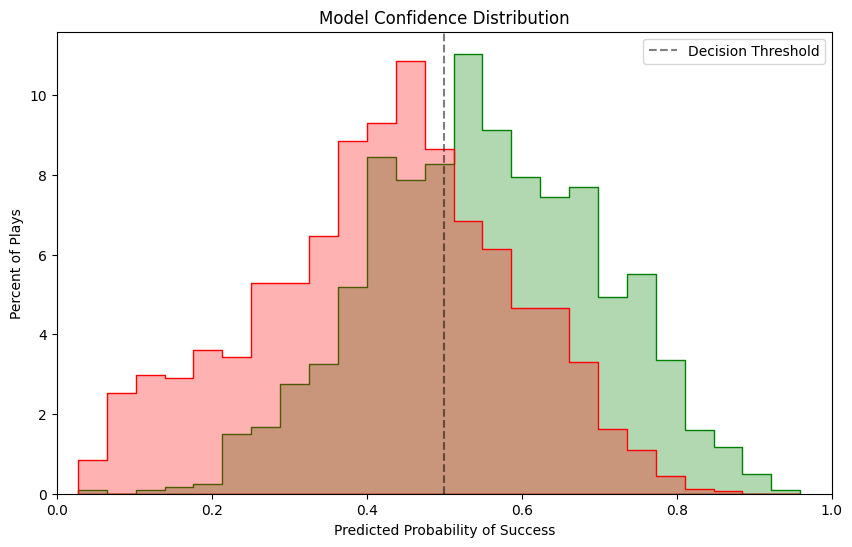

In [136]:
# prepare data using y_probs and y_test
viz_df = pd.DataFrame({
    'Probability': y_probs,
    'Outcome': y_test.map({1: 'Success', 0: 'Failure'})
})

# create histogram
plt.figure(figsize=(10, 6))

sns.histplot(
    data=viz_df,
    x='Probability',
    hue='Outcome',
    element='step',
    stat='percent',
    common_norm=False,
    bins=25,
    palette={'Success': 'green', 'Failure': 'red'},
    alpha=0.3
)

# add context lines
plt.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Decision Threshold')

plt.title('Model Confidence Distribution')
plt.xlabel('Predicted Probability of Success')
plt.ylabel('Percent of Plays')
plt.xlim(0, 1)
plt.legend()
plt.show()

    

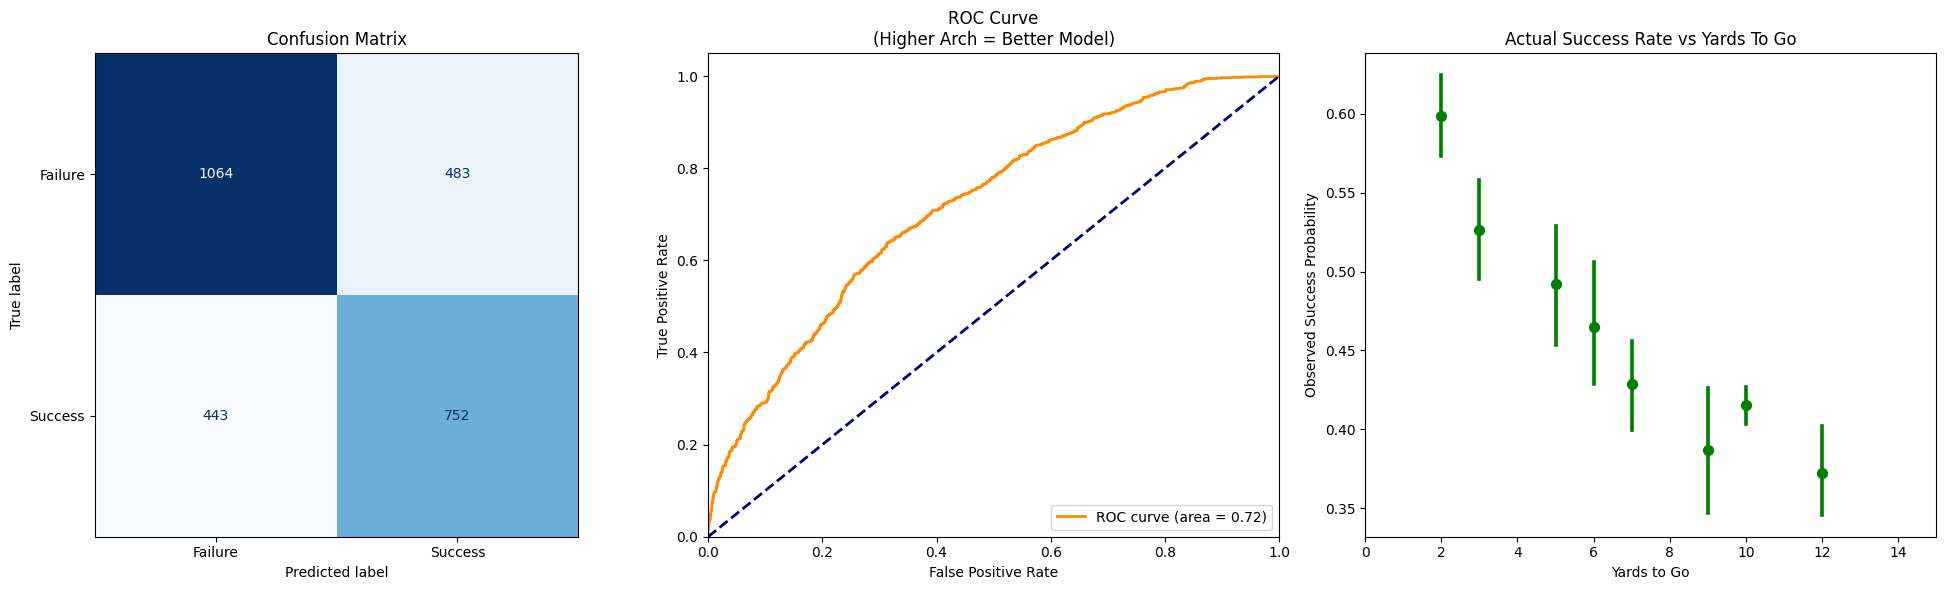

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
## create Confusion Matrix, ROC Curve and SHA Dependence visualizations for final model

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

#------------Confusion Matrix----------------
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failure', 'Success'])
disp.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix')

#--------------ROC Curve--------------------
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve\n(Higher Arch = Better Model)')
axes[1].legend(loc="lower right")

#--------------SHAP Dependence---------------
# plot actual success rate by 'ydstogo' which the model consistently saw as a top important feature
sns.regplot(
    data=model_ready_df,
    x='ydstogo',
    y='success',
    x_bins=15,
    fit_reg=False,
    ax=axes[2],
    color='green',
    marker='o'
)

axes[2].set_title('Actual Success Rate vs Yards To Go')
axes[2].set_xlabel('Yards to Go')
axes[2].set_ylabel('Observed Success Probability')
axes[2].set_xlim(0, 15)

plt.tight_layout()
plt.show()
             

Top 10 Features of Final Model
                       Feature  Importance
36              qb_blitz_grade    0.073393
21          yards_to_goal_diff    0.053627
13          possession_seconds    0.051296
19              active_rec_epa    0.046774
2                         down    0.040804
7   posteam_timeouts_remaining    0.032223
0                 yardline_100    0.028788
18               active_qb_epa    0.028129
3                      ydstogo    0.025881
1       game_seconds_remaining    0.020712


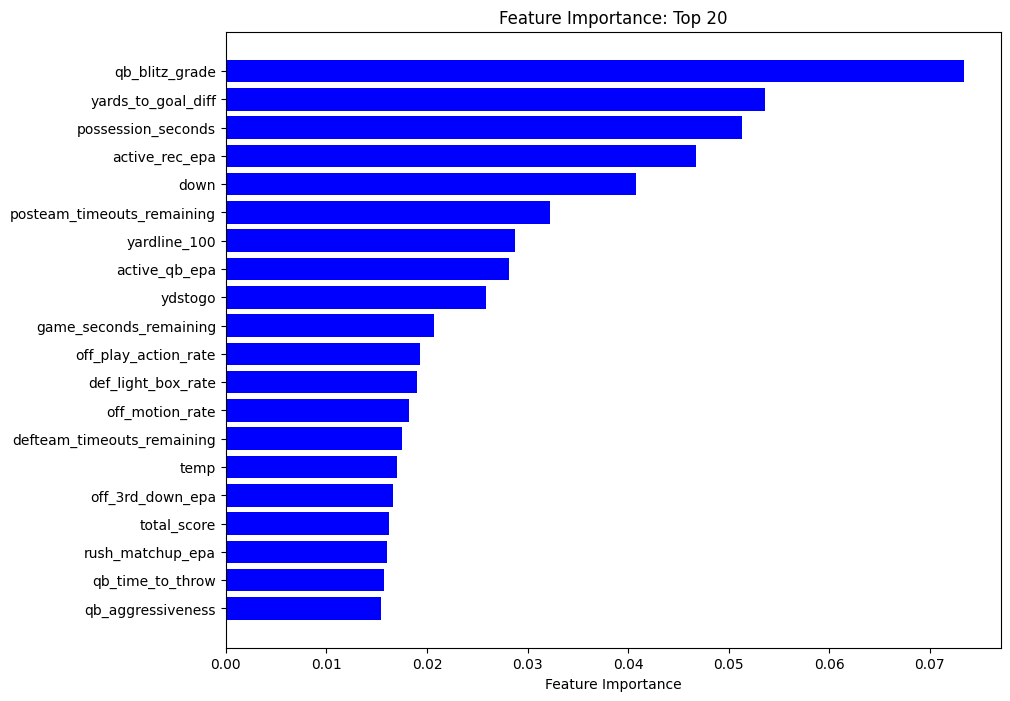

In [138]:
## feature importance plot for best_model

importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print('Top 10 Features of Final Model')
print(feature_importance_df.head(10))

# plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:20][::-1], feature_importance_df['Importance'][:20][::-1], color='blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance: Top 20')
plt.show()

In [140]:
print(f'Number of features: {len(selected_features)}')
print(f'Number of model importances: {len(best_model.feature_importances_)}')

features_used = selected_features.to_list()
print(features_used)

Number of features: 54
Number of model importances: 54
['yardline_100', 'game_seconds_remaining', 'down', 'ydstogo', 'shotgun', 'no_huddle', 'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'temp', 'wind', 'total_score', 'cumm_run_yards', 'possession_seconds', 'top_diff', 'posteam_home', 'qb_matchup_epa', 'rush_matchup_epa', 'active_qb_epa', 'active_rec_epa', 'active_rush_epa', 'yards_to_goal_diff', 'yards_gained_prev_play', 'clutch_index', 'number_of_pass_rushers', 'num_rb', 'num_te', 'form_EMPTY', 'form_SHOTGUN', 'form_SINGLEBACK', 'form_UNDER CENTER', 'pers_13', 'active_def_epa', 'box_mismatch', 'is_passing_down', 'team_game_success_rate', 'qb_blitz_grade', 'def_blitz_rate', 'def_box_avg', 'def_light_box_rate', 'off_motion_rate', 'off_play_action_rate', 'off_screen_rate', 'off_rpo_rate', 'qb_time_to_throw', 'qb_intended_air_yards', 'qb_aggressiveness', 'qb_cpoe', 'off_alpha_wopr', 'off_avg_yac', 'off_3rd_down_epa', 'off_rz_td_rate', 'def_3rd_down_epa

### SAVE FINAL MODEL

In [ ]:
import joblib

# define artifacts to save
artifacts = {
    'model': best_model,
    'features': selected_features.tolist(),
    'accuracy': accuracy_score(y_test, y_pred_tuned)
}

# save to file
joblib.dump(artifacts, 'epa_succes_model_v1.pkl')
print('Model saved')
print(f'Saved with {len(selected_features)} features and {artifacts['accuracy']:.4f} accuracy')

### SAVE FINAL DATAFRAME

In [ ]:
modern_only_df.to_parquet('data/enriched_plays_v1.parquet')
print('Data saved')

# PHASE 1 SUMMARY: THE MICRO MODEL (BASELINE NFL GAME KNOWLEDGE)

## OBJECTIVE
To build a baseline model capable of predicting the success (positive EPA) of any given NFL play based solely on pre-snap information.

## METHODOLOGY
- **Data**: 13,000+ plays from post season NFL games from years 2016-2024
- **Features**: Engineered 70+ signals including Scheme (motion, box counts), QB traits (CPOE, aggressiveness), and Situational Context (down, distance, score, weather)
- **Model**: XGBoost Classifier tuned for probability calibration

## RESULTS
- **Accuracy**: ~66% (state-of-the-art for public EPA models usually tops out at ~70% due to the randomness of NFL games)
- **Key Insight**: The model is highly calibrated and conservative.  It rarely predicts >80% success unless the situation is overwhelmingly favorable to the offense
- **Top Predictive Features**:
  1. 'qb_blitz_grade' (what is the QB's EPA against the blitz)
  2. 'yards_to_goal_diff' (how close to the opponent's endzone is the offense)
  3. 'possession_seconds' (how long has this offensive possession been in seconds)
  4. 'active_rec_epa' (what is the preceding reg season epa of the active receiving corps for this play)
  5. 'down' (what down is it)
  6. 'posteam_timeouts_remaining' (how many timeouts does the offense have)
  7. 'yardline_100' (where is the ball currently on the field)
  8. 'active_qb_epa' (what is the reg season epa of the quarterback for this play)
  9. 'ydstogo' (how many yards to obtain a 1st down)
  10. 'game_seconds_remaining' (how much time is remaining in the game)